Основные цели этого задания:

- попрактиковаться в анализе временных рядов,
- научиться извлекать дополнительные признаки для прогнозирования временного ряда,
- проверять качество модели на отложенной выборке.

Задача: спрогнозировать число пассажиров авиакомпании помесячно.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format


import warnings
warnings.filterwarnings('ignore')

План:

1. _Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике. Найдите и удалите пропуски, если они есть. Поменяйте тип столбца с временными отсечками в datetime. Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает._

In [2]:
df = pd.read_csv('AirPassengers.csv')
display(df.sample(10))

,Month,#Passengers
60,1954-01,204
15,1950-04,135
77,1955-06,315
84,1956-01,284
112,1958-05,363
59,1953-12,201
127,1959-08,559
101,1957-06,422
102,1957-07,465
118,1958-11,310


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
# Переименовать столбец '#Passengers' в 'Passengers'
df = df.rename(columns={'#Passengers': 'passengers'})

In [5]:
# Изменим тип данных Period с object на datetime64.
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")

# Установим столбец 'Month' в качестве индекса DataFrame
df.set_index('Month', inplace=True)

# Проверим, что индекс монотонно возрастает
print(df.index.is_monotonic_increasing)

True


2. _Проанализируйте временной ряд_

Оставьте для аналитики лишь с 1952 по 1957 год (включительно).

In [6]:
# Делаем срез в данных
data = df['1952':'1957']
print(df.index.min(), data.index.max())

1949-01-01 00:00:00 1957-12-01 00:00:00


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1952-01-01 to 1957-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

Есть ли тренд?

Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?

Является ли ряд стационарным и почему?

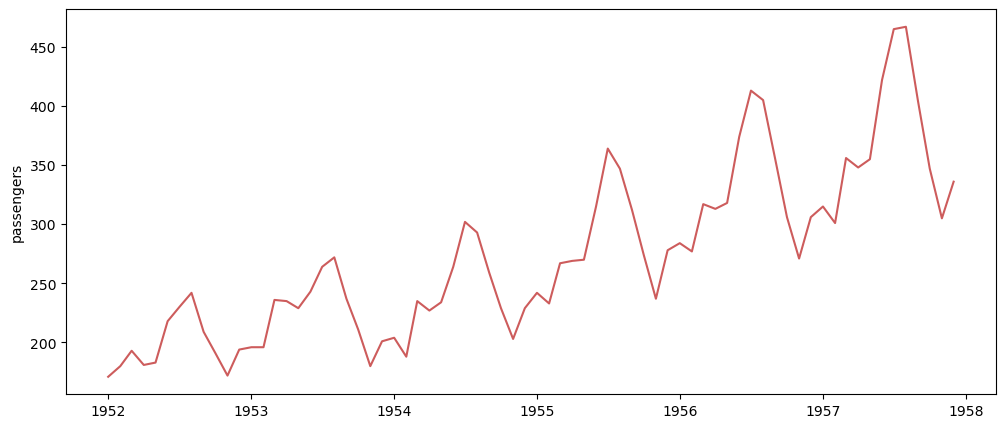

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])
ax.plot(data['passengers'], c='indianred', label='passengers')
ax.set_ylabel('passengers');

In [9]:
data_quart_sum = data.resample('1Q').sum()
data_quart_sum.head(24)

,passengers
Month,
1952-03-31,544
1952-06-30,582
1952-09-30,681
1952-12-31,557
1953-03-31,628
1953-06-30,707
1953-09-30,773
1953-12-31,592
1954-03-31,627


In [10]:
data_year_sum = data.resample('1Y').sum()
data_year_sum.head(6)

,passengers
Month,
1952-12-31,2364
1953-12-31,2700
1954-12-31,2867
1955-12-31,3408
1956-12-31,3939
1957-12-31,4421


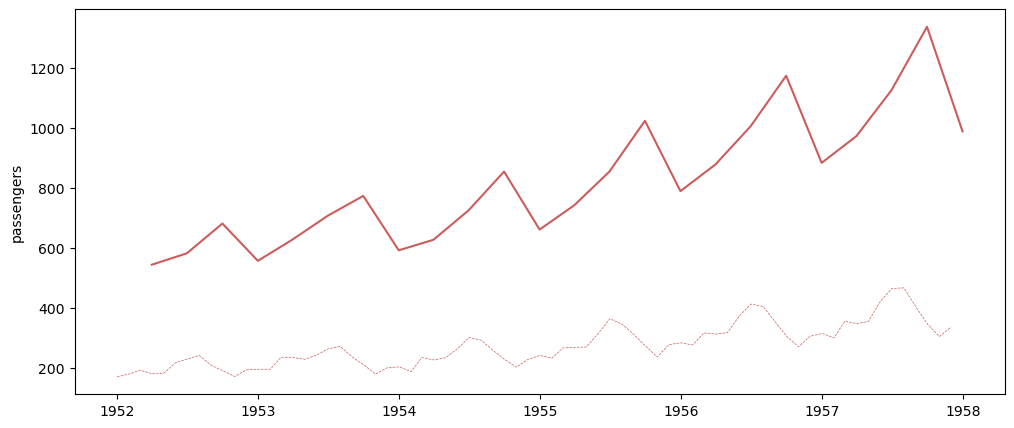

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data['passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(data_quart_sum['passengers'], c='indianred', label='Revenue_per_quartal')
ax.set_ylabel('passengers');

In [12]:
data_rolling_mean = data[['passengers']].rolling(3).mean()

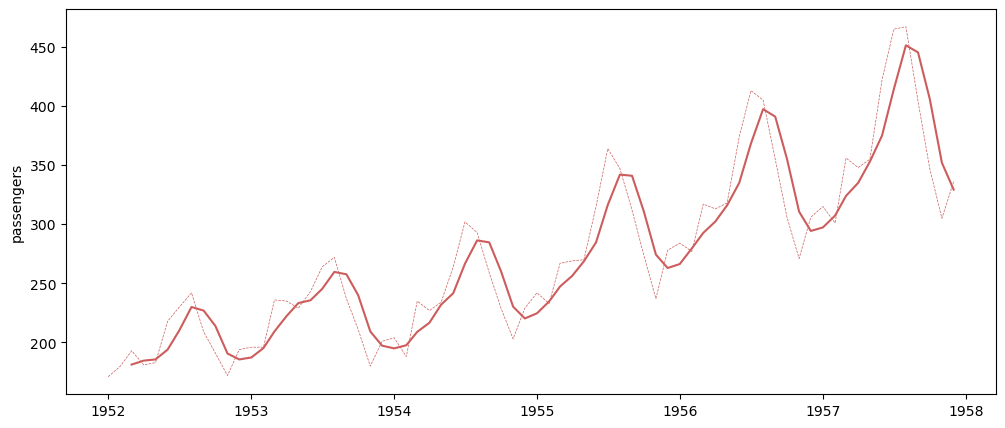

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data['passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(data_rolling_mean['passengers'], c='indianred', label='Passengers_per_quartal')
ax.set_ylabel('passengers');

In [14]:
decomposed = seasonal_decompose(data['passengers']) 

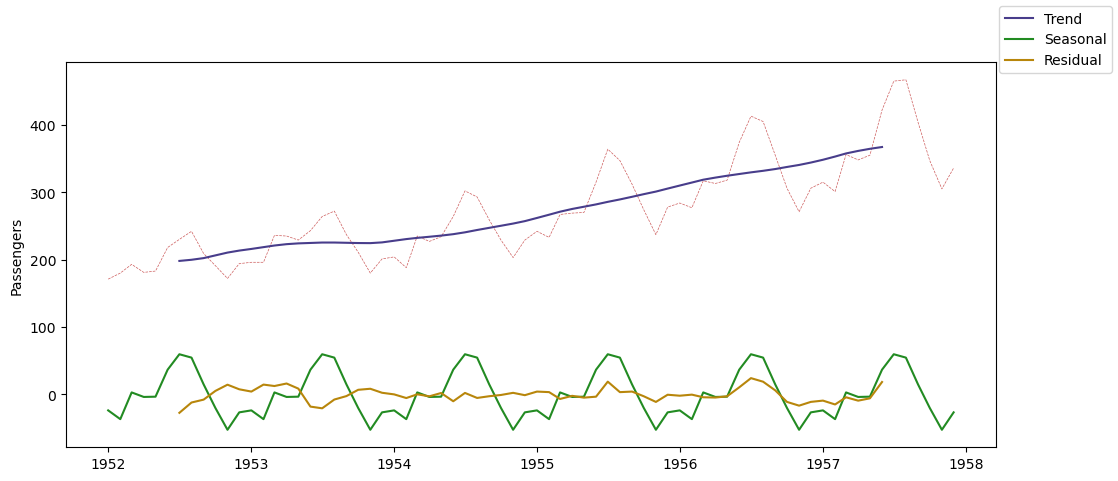

In [15]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data['passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend();

In [16]:
decomposed.seasonal

Month
1952-01-01   -23.87
1952-02-01   -36.90
1952-03-01     2.80
1952-04-01    -3.93
1952-05-01    -3.54
              ...  
1957-08-01    54.46
1957-09-01    14.70
1957-10-01   -20.25
1957-11-01   -52.68
1957-12-01   -26.81
Name: seasonal, Length: 72, dtype: float64

- Да, в данных присутствует сезонность. Исходя из периодичности колебаний, можно сказать, что это ежегодная (годовая) сезонность

In [17]:
sales_diffs = data['passengers'] - data['passengers'].shift(fill_value=0)

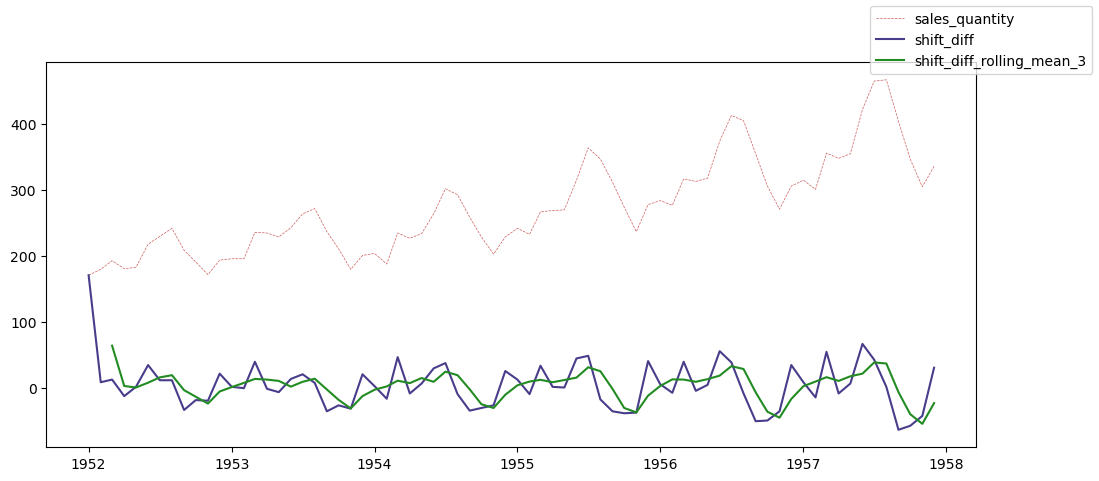

In [18]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data['passengers'], c='indianred', linewidth=0.5, linestyle='--', label='sales_quantity')
ax.plot(sales_diffs, c='darkslateblue', label='shift_diff')
ax.plot(sales_diffs.rolling(3).mean(), c='forestgreen', label='shift_diff_rolling_mean_3')

fig.legend();

Постройте график, чтобы оценить автокорреляцию и сделайте выводы

У какого сдвига самая высокая автокорреляция?

Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

In [19]:
acf = sm.tsa.acf(data['passengers'])
acf.shape

(19,)

In [20]:
acf

array([1.        , 0.89400793, 0.74549489, 0.61531598, 0.50234066,
       0.43030094, 0.38667   , 0.35354755, 0.35686359, 0.40011587,
       0.4555686 , 0.53720175, 0.58170785, 0.49625454, 0.37523856,
       0.27647025, 0.19148319, 0.13560224, 0.09421318])

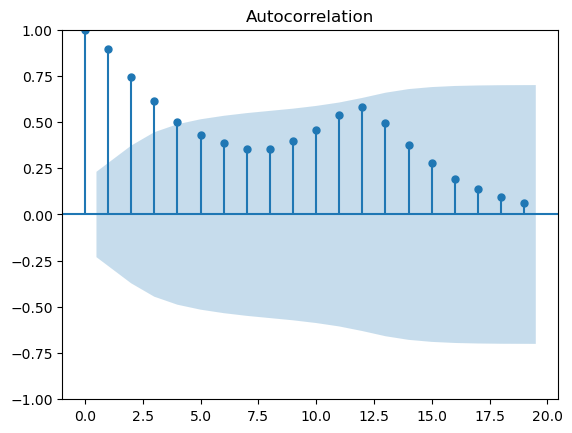

In [21]:
fig = tsaplots.plot_acf(data['passengers'])
plt.show() 

- Самое высокое значение автокорреляции (0.89400793) наблюдается при сдвиге (лаге) 1.
- Это указывает на сильную положительную корреляцию между текущими значениями и значениями с лагом 1.
- Значения автокорреляции постепенно уменьшаются с увеличением лага, что свидетельствует о наличии тренда в данных.
- Постепенное снижение значений автокорреляции с увеличением лага подтверждает, что в данных присутствует тренд.
- Наличие высоких значений автокорреляции на первых лагах (особенно лаг 1) говорит о том, что временной ряд не является стационарным и имеет тренд.

3. _Подготовьте данные к обучению линейной модели_

Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)

Воспользуйтесь наработками из скринкастов.

Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.

Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».

In [22]:
def make_features(data, lags, rolling_means):
    """
    Создает новые признаки на основе входных данных:
    - Календарные признаки: год, месяц, квартал
    - Отстающие значения (lags)
    - Скользящие средние (rolling means)
    
    Параметры:
    data (pd.DataFrame): Исходные данные
    lags (list): Список сдвигов для создания признаков отстающих значений
    rolling_means (list): Список размеров окна для создания признаков скользящих средних
    """
    # Календарные признаки
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    # Отстающие значения
    for i in lags:
        data[f'lag_{i}'] = data['passengers'].shift(i)
    
    # Скользящие средние
    for m in rolling_means:
        data[f'rolling_mean_{m}'] = data['passengers'].rolling(m).mean().shift(1)
    
    return data


Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.

In [23]:
data_with_features = make_features(data[['passengers']].copy(), [3, 6, 12], [7, 14, 30])

Удалите наблюдения с пропусками в новых переменных

In [24]:
data_with_features = data_with_features.dropna()
data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 1954-07-01 to 1957-12-01
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passengers       42 non-null     int64  
 1   year             42 non-null     int32  
 2   month            42 non-null     int32  
 3   quarter          42 non-null     int32  
 4   lag_3            42 non-null     float64
 5   lag_6            42 non-null     float64
 6   lag_12           42 non-null     float64
 7   rolling_mean_7   42 non-null     float64
 8   rolling_mean_14  42 non-null     float64
 9   rolling_mean_30  42 non-null     float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 3.1 KB


Разделите данные на признаки и целевую переменную.

In [25]:
train, test = train_test_split(data_with_features.dropna(), shuffle=False, test_size=0.25)
train = train.dropna()

Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [26]:
train_target = train['passengers']
train_features = train.drop(['passengers'], axis=1)
test_target = test['passengers']
test_features = test.drop(['passengers'], axis=1)

4. _Обучите линейную модель машинного обучения и оцените ее качество_

Обучите линейную модель на обучающей части данных.

Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.

In [27]:
scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

model = LinearRegression()
model.fit(train_features_norm, train_target)

train_prediction = pd.Series(model.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features_norm))
test_prediction.index = test_features.index

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_prediction))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 5.56984885019599
MAE тестовой выборки:  14.103600066565145


Визуализируйте реальный временной ряд и прогнозные значения. 

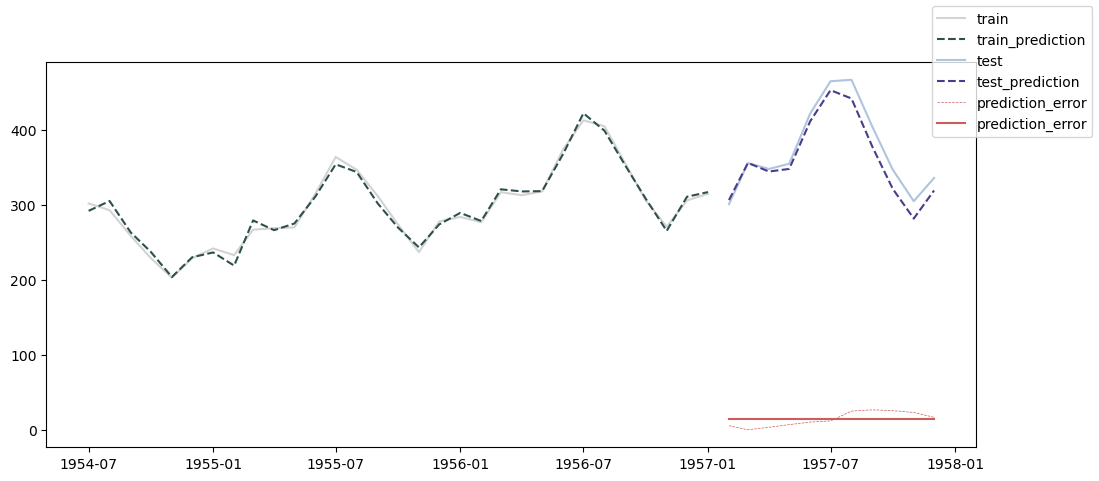

In [28]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

5. _Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год_

Возьмите из источника необходимый срез данных.

In [29]:
# Делаем срез в данных
postpone_data = df['1958':'1960']
print(postpone_data.index.min(), postpone_data.index.max())

1958-01-01 00:00:00 1960-12-01 00:00:00


Подготовьте данные к прогнозированию.

Добавьте признаки с помощью реализованной ранее функции.

In [30]:
postpone_data_with_features = make_features(postpone_data[['passengers']].copy(), [3, 6, 12], [7, 14, 30])
postpone_data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1958-01-01 to 1960-12-01
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passengers       36 non-null     int64  
 1   year             36 non-null     int32  
 2   month            36 non-null     int32  
 3   quarter          36 non-null     int32  
 4   lag_3            33 non-null     float64
 5   lag_6            30 non-null     float64
 6   lag_12           24 non-null     float64
 7   rolling_mean_7   29 non-null     float64
 8   rolling_mean_14  22 non-null     float64
 9   rolling_mean_30  6 non-null      float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 2.7 KB


Удалите наблюдения с пропусками.

Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.

In [31]:
postpone_data_with_features = postpone_data_with_features.dropna()
len(postpone_data_with_features)

6

In [32]:
postpone_data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 1960-07-01 to 1960-12-01
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passengers       6 non-null      int64  
 1   year             6 non-null      int32  
 2   month            6 non-null      int32  
 3   quarter          6 non-null      int32  
 4   lag_3            6 non-null      float64
 5   lag_6            6 non-null      float64
 6   lag_12           6 non-null      float64
 7   rolling_mean_7   6 non-null      float64
 8   rolling_mean_14  6 non-null      float64
 9   rolling_mean_30  6 non-null      float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 456.0 bytes


 Отделите целевую переменную от признаков.

Постройте прогноз с помощью обученной ранее линейной модели.

Рассчитайте значение метрики качества на отложенной выборке.

In [33]:
# Обучение модели на данных до 1958 года
train = data_with_features[data_with_features.index < '1958']
train_target = train['passengers']
train_features = train.drop(['passengers'], axis=1)

scaler = StandardScaler()
scaler.fit(train_features)
train_features_norm = scaler.transform(train_features)

model = LinearRegression()
model.fit(train_features_norm, train_target)

postpone_target = postpone_data_with_features['passengers']
postpone_features = postpone_data_with_features.drop(['passengers'], axis=1)

# Применяем ту же стандартизацию, что и для обучающей выборки
postpone_features_norm = scaler.transform(postpone_features)
postpone_prediction = pd.Series(model.predict(postpone_features_norm))
postpone_prediction.index = postpone_features.index

print("MAE на отложенной выборке:", mean_absolute_error(postpone_target, postpone_prediction))

MAE на отложенной выборке: 23.09504801745435


Визуализируйте реальный временной ряд и прогнозные значения.

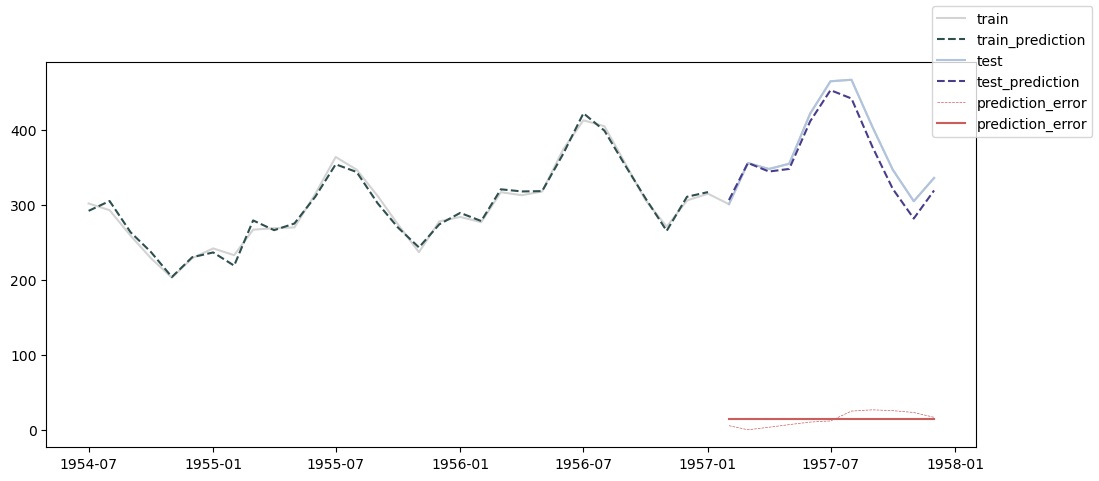

In [34]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

6. Значение метрики MAE на отложенной выборке должно быть не более 35.

In [35]:
mae_postpone = mean_absolute_error(postpone_target, postpone_prediction)
if mae_postpone <= 35:
    print("Метрика MAE на отложенной выборке в норме")
else:
    print("Метрика MAE на отложенной выборке превышает 35")

Метрика MAE на отложенной выборке в норме


   - Построен график, отображающий реальные и прогнозные значения пассажиропотока.
   - Визуализация позволяет оценить качество прогноза и его соответствие реальным данным.

Таким образом, можно сделать вывод, что линейная регрессионная модель, обученная на нормализованных данных с добавленными признаками, показала удовлетворительное качество прогнозирования на тестовой выборке, удовлетворяя заданному критерию (MAE <= 35).

__Задание ПРО__

Основные цели этого задания:

научиться определять стационарность ряда статистическими методами

познакомиться с библиотечными решениями для прогнозирования временных рядов и попрактиковаться в их использовании

Задача: спрогнозировать число пассажиров авиакомпании помесячно. В отличие от обычного задания, будем использовать готовые библиотечные решения.

План:

1. _Загрузите данные из источника по ссылке, и подготовьте к прогнозированию. Оставьте только данные с 1952 по 1957 год включительно._

In [36]:
# Делаем срез в данных
data_pro = df['1952':'1957']
print(df.index.min(), data.index.max())

1949-01-01 00:00:00 1957-12-01 00:00:00


In [37]:
data_pro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1952-01-01 to 1957-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


2. _Визуализируйте временной ряд и продублируйте свои выводы из основного задания о том, имеются ли у ряда тренд, сезонность и является ли он стационарным._

In [38]:
decomposed = seasonal_decompose(data_pro['passengers']) 

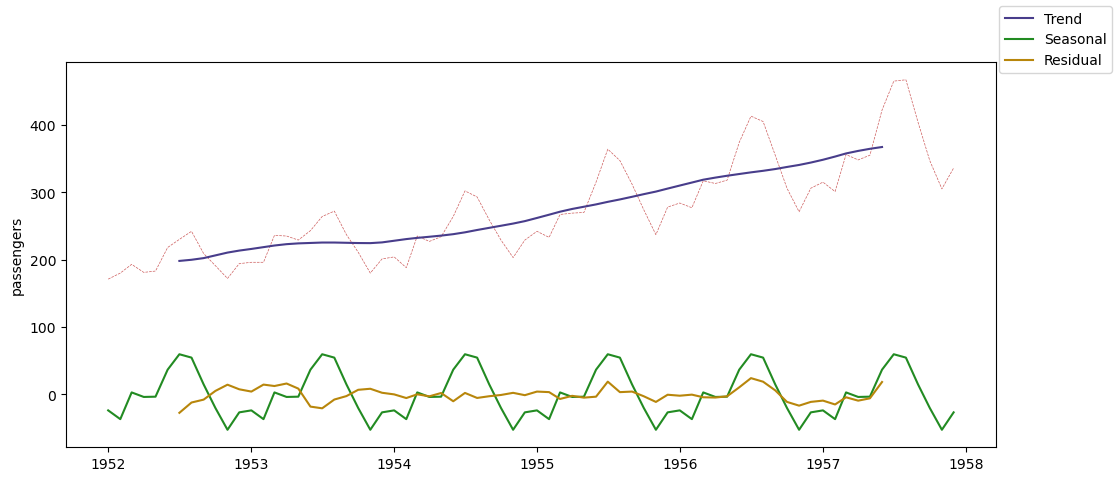

In [39]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data_pro['passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('passengers')

fig.legend();

Из графика мы можем сделать следующие выводы:

- Тренд: На графике отчетливо виден восходящий тренд в данных, что свидетельствует о постепенном росте количества пассажиров со временем.

- Сезонность: Также на графике наблюдается четкая сезонная компонента, которая проявляется в виде регулярных колебаний вокруг тренда. Это говорит о наличии сезонности в ряде данных.

- Стационарность: Временной ряд не является стационарным, так как на нем присутствует явно выраженный тренд. Для того, чтобы ряд стал стационарным, необходимо будет устранить этот тренд, например, с помощью дифференцирования.

3. _Разделите данные на обучающую и валидационную части._

In [40]:
train, test = train_test_split(data_pro.dropna(), shuffle=False, test_size=0.25)
train = train.dropna()
test = test.dropna()

In [41]:
train_target = train['passengers']
train_features = train.drop(['passengers'], axis=1)
test_target = test['passengers']
test_features = test.drop(['passengers'], axis=1)

4. _Обучите AR-модель._

Ознакомьтесь с документацией библиотечной модели, которую необходимо использовать в этом задании.
Повторите теорию из видео-урока “Прогнозирование временных рядов” и определите, какой гиперпараметр библиотечной модели отвечает за настройку AR-модели.

Переберите несколько вариантов значений гиперпараметров и выберите лучший по значению метрики MAE на валидационной выборке.
Визуализируйте обучающую и валидационную части данных, а также прогнозные значения, полученные с помощью лучшей AR-модели.

Лучшее количество лагов для AR-модели: 1
Лучшее значение MAE на валидационной выборке: 20.01
MAE тестовой выборки: 56.19
MAE обучающей выборки: 20.01


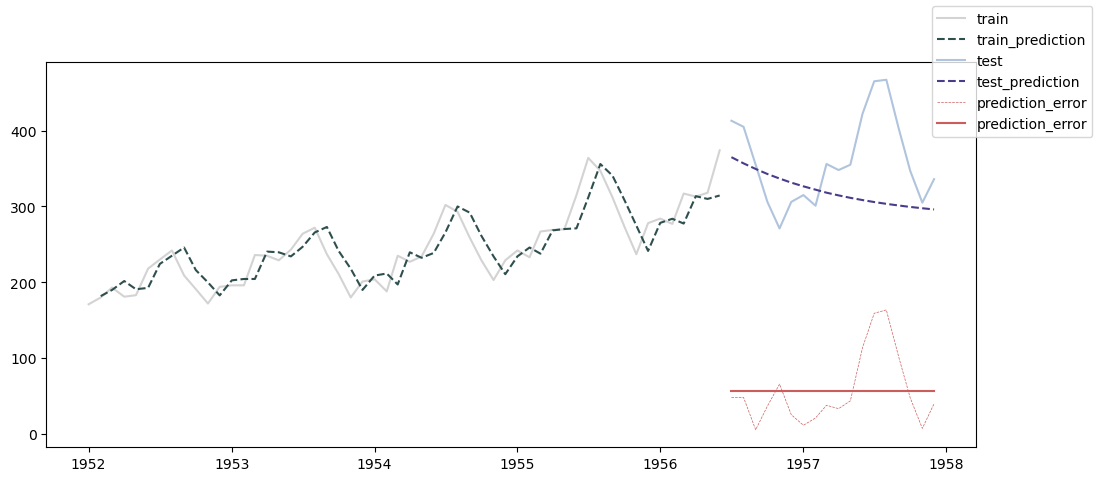

In [42]:
# Перебор различных значений lags
best_mae = float('inf')
best_lags = None
for lags in [1, 2, 3]:
    model = sm.tsa.AutoReg(train_target, lags=lags, trend='c').fit()
    val_prediction = model.predict(start=train_target.index[0], end=train_target.index[-1])
    non_nan_mask = ~(pd.isnull(train_target) | pd.isnull(val_prediction))
    mae = mean_absolute_error(train_target[non_nan_mask], val_prediction[non_nan_mask])
    if mae < best_mae:
        best_mae = mae
        best_lags = lags

print(f"Лучшее количество лагов для AR-модели: {best_lags}")
print(f"Лучшее значение MAE на валидационной выборке: {best_mae:.2f}")

# Обучение финальной модели на всех данных
AR_model = sm.tsa.AutoReg(train_target, lags=best_lags, trend='c').fit()

# MAE обучающей выборки и MAE тестовой выборки
train_prediction = AR_model.predict(start=train_target.index[0], end=train_target.index[-1])
test_prediction = AR_model.predict(start=test_target.index[0], end=test_target.index[-1])

non_nan_mask = ~(pd.isnull(test_target) | pd.isnull(test_prediction))
ar_test_mae = mean_absolute_error(test_target[non_nan_mask], test_prediction[non_nan_mask])
print(f"MAE тестовой выборки: {ar_test_mae:.2f}")

non_nan_mask = ~(pd.isnull(train_target) | pd.isnull(train_prediction))
ar_train_mae = mean_absolute_error(train_target[non_nan_mask], train_prediction[non_nan_mask])
print(f"MAE обучающей выборки: {ar_train_mae:.2f}")

fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * len(test['passengers']), index=test.index)

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();


- В документации библиотеки statsmodels для построения авторегрессионной (AR) модели используется класс sm.tsa.AutoReg. Ключевым гиперпараметром, отвечающим за настройку AR-модели, является параметр lags.

5. _Обучите ARMA-модель_

С помощью документации и теории из урока определите, какие гиперпараметры отвечают именно за настройку ARMA-модели.

Переберите несколько вариантов значений гиперпараметров и выберите лучший по значению метрики MAE на валидационной выборке.

Визуализируйте обучающую и валидационную части данных, а также прогнозные значения, полученные с помощью лучшей ARMA-модели.

Лучшие параметры ARMA-модели: p=5, q=3
Лучшее значение MAE на тестовой выборке: 50.03
MAE на тестовой выборке: 50.03
MAE на обучающей выборке: 17.35


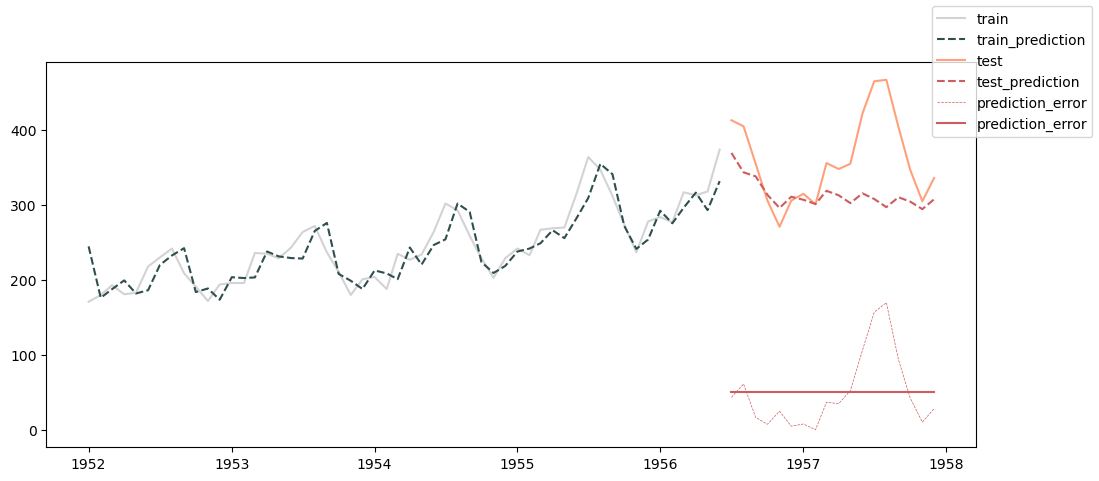

In [43]:
# Перебор различных значений p (порядок AR-модели) и q (порядок MA-модели)
best_mae = float('inf')
best_p, best_q = None, None
for p in [1, 2, 3, 4, 5]:
    for q in [1, 2, 3, 4, 5]:
        model = sm.tsa.ARIMA(train_target, order=(p, 0, q), trend='c').fit()
        train_prediction = model.predict(start=train_target.index[0], end=train_target.index[-1])
        train_mae = mean_absolute_error(train_target, train_prediction)
        val_prediction = model.predict(start=test_target.index[0], end=test_target.index[-1])
        val_mae = mean_absolute_error(test_target, val_prediction)
        
        if val_mae < best_mae:
            best_mae = val_mae
            best_p, best_q = p, q

print(f"Лучшие параметры ARMA-модели: p={best_p}, q={best_q}")
print(f"Лучшее значение MAE на тестовой выборке: {best_mae:.2f}")

# Обучение финальной ARMA-модели на всех данных
ARMA_model = sm.tsa.ARIMA(train_target, order=(best_p, 0, best_q)).fit()

# Прогноз на тестовой выборке
test_prediction = ARMA_model.predict(start=test_target.index[0], end=test_target.index[-1])
arma_test_mae = mean_absolute_error(test_target, test_prediction)
train_prediction = ARMA_model.predict(start=train_target.index[0], end=train_target.index[-1])
arma_train_mae = mean_absolute_error(train_target, train_prediction)
print(f"MAE на тестовой выборке: {arma_test_mae:.2f}")
print(f"MAE на обучающей выборке: {arma_train_mae:.2f}")

# Визуализация обучающей, валидационной и тестовой выборок, а также прогнозных значений
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * len(test['passengers']), index=test.index)

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsalmon', label='test')
ax.plot(test_prediction, c='indianred', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

- p (порядок авторегрессионной части, AR)
   - Определяет количество предыдущих значений временного ряда, которые будут использованы для прогнозирования текущего значения.

- q (порядок модели скользящего среднего, MA)
   - Определяет количество предыдущих ошибок прогноза, которые будут использованы для моделирования текущей ошибки.

6. _Обучите ARIMA-модель_

Повторите те же этапы, что и в предыдущих шагах. При переборе значений параметра, отвечающего за дифференцирование, перебирайте значения с шагом 1, не перебирайте слишком большие значения (хватит до 3).

Лучшие параметры ARIMA-модели: p=5, d=1, q=4
Лучшее значение MAE на тестовой выборке: 33.48
MAE на тестовой выборке: 33.48
MAE на обучающей выборке: 19.44


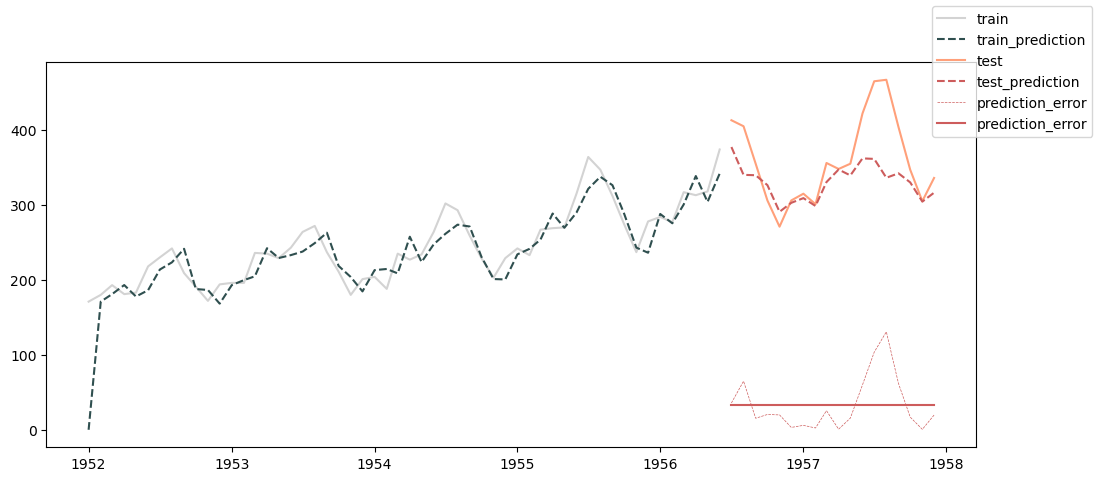

In [44]:
# Перебор различных значений p (порядок AR-модели), d (порядок дифференцирования) и q (порядок MA-модели)
best_mae = float('inf')
best_p, best_d, best_q = None, None, None

# Более мелкий шаг перебора
for p in range(0, 6, 1):
    for d in range(0, 3, 1):
        for q in range(0, 6, 1):
            model = sm.tsa.ARIMA(train_target, order=(p, d, q)).fit()
            train_prediction = model.predict(start=train_target.index[0], end=train_target.index[-1])
            train_mae = mean_absolute_error(train_target, train_prediction)
            val_prediction = model.predict(start=test_target.index[0], end=test_target.index[-1])
            val_mae = mean_absolute_error(test_target, val_prediction)
            
            if val_mae < best_mae:
                best_mae = val_mae
                best_p, best_d, best_q = p, d, q

print(f"Лучшие параметры ARIMA-модели: p={best_p}, d={best_d}, q={best_q}")
print(f"Лучшее значение MAE на тестовой выборке: {best_mae:.2f}")

# Обучение финальной ARIMA-модели на всех данных
ARIMA_model = sm.tsa.ARIMA(train_target, order=(best_p, best_d, best_q)).fit()

# Прогноз на тестовой выборке
test_prediction = ARIMA_model.predict(start=test_target.index[0], end=test_target.index[-1])
arima_test_mae = mean_absolute_error(test_target, test_prediction)
train_prediction = ARIMA_model.predict(start=train_target.index[0], end=train_target.index[-1])
arima_train_mae = mean_absolute_error(train_target, train_prediction)
print(f"MAE на тестовой выборке: {arima_test_mae:.2f}")
print(f"MAE на обучающей выборке: {arima_train_mae:.2f}")

# Визуализация обучающей, валидационной и тестовой выборок, а также прогнозных значений
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * len(test['passengers']), index=test.index)

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsalmon', label='test')
ax.plot(test_prediction, c='indianred', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();


- p (порядок авторегрессионной части, AR)
   - Определяет количество предыдущих значений временного ряда, которые будут использованы для прогнозирования текущего значения.

- d (порядок дифференцирования, I)
   - Определяет, сколько раз необходимо применить дифференцирование к исходному ряду, чтобы сделать его стационарным.

- q (порядок модели скользящего среднего, MA)
   - Определяет количество предыдущих ошибок прогноза, которые будут использованы для моделирования текущей ошибки.

7. _Сравните значение параметра, отвечающего за дифференцирование, с необходимым количеством дифференцирований для получения стационарного ряда._

Для того, чтобы понять, является ли ряд стационарным, используется расширенный тест Дики-Фуллера (документация). Выражаясь простым языком, этот статистический тест проверяет гипотезу о том, что ряд является нестационарным. Чем отрицательнее значение критерия, тем сильнее уверенность в том, что гипотезу можно отвергнуть. Если результат теста статистически значимый, то гипотеза отвергается, а ряд считается стационарным. Примеры проведения теста над разными временными рядами можете изучить в статье.

Для того, чтобы понять, сколько раз нужно продифференцировать ряд, чтобы получить стационарный ряд, используйте метод diff и подберите минимальное необходимое количество дифференцирований, после которых согласно тесту Дики-Фуллера временной ряд станет стационарным.

Сравните результат с подобранным в шаге 6 параметром дифференцирования.

In [45]:
# Тест Дики-Фуллера на исходном ряде
result = adfuller(train_target)
print(f"Статистика теста Дики-Фуллера: {result[0]}")
print(f"p-значение: {result[1]}")
if result[1] < 0.05:
    print("Ряд является стационарным")
else:
    print("Ряд является нестационарным")

Статистика теста Дики-Фуллера: 3.033593508259671
p-значение: 1.0
Ряд является нестационарным


In [46]:
# Проверим стационарность после дифференцирования
diff_target = train_target.diff().dropna()
result = adfuller(diff_target)
print(f"Статистика теста Дики-Фуллера после 1-го дифференцирования: {result[0]}")
print(f"p-значение: {result[1]}")
if result[1] < 0.05:
    print("Ряд является стационарным после 1-го дифференцирования")
else:
    # Продифференцируем ряд еще раз
    diff_target = diff_target.diff().dropna()
    result = adfuller(diff_target)
    print(f"Статистика теста Дики-Фуллера после 2-го дифференцирования: {result[0]}")
    print(f"p-значение: {result[1]}")
    if result[1] < 0.05:
        print("Ряд является стационарным после 2-го дифференцирования")
    else:
        print("Ряд остается нестационарным даже после 2-го дифференцирования")

Статистика теста Дики-Фуллера после 1-го дифференцирования: -1.39687556383135
p-значение: 0.5837730924704103
Статистика теста Дики-Фуллера после 2-го дифференцирования: -14.528216466365604
p-значение: 5.3847200406173264e-27
Ряд является стационарным после 2-го дифференцирования


In [47]:
print(f"Параметр дифференцирования, найденный в цикле шага 6: d={best_d}")
print(f"Необходимое количество дифференцирований для стационарности: 2")

Параметр дифференцирования, найденный в цикле шага 6: d=1
Необходимое количество дифференцирований для стационарности: 2


- Необходимое количество дифференцирований для стационарности 2 вносим в код выше модель выдает:
   - Лучшие параметры ARIMA-модели: p=5, d=2, q=3
   - Лучшее значение MAE на тестовой выборке: 37.74
   - MAE на тестовой выборке: 37.74
   - MAE на обучающей выборке: 22.29

- Необходимое количество дифференцирований for d in range(0, 3, 1) модель выдает:
   - Лучшие параметры ARIMA-модели: p=5, d=1, q=4
   - Лучшее значение MAE на тестовой выборке: 33.48
   - MAE на тестовой выборке: 33.48
   - MAE на обучающей выборке: 19.44

8. _Обучите SARIMA-модель_

Согласно документации определите, какие гиперпараметры необходмо указать, чтобы модель имела тип SARIMA

Подберите значения гиперпараметров, чтобы получить модель, не уступающую по качеству предыдущим. Число гиперпараметров очень велико, поэтому перебирать их все крайне не рекомендуется. Традиционным способом поиска этих гиперпараметров является метод Бокса-Дженкинса, описанный, например, статье. В рамках этого задания рекомендуется “не закапываться”, а попробовать подобрать гиперпараметры, воспользовавшись следующими рекомендациями:

Параметр сезонности можно определить, исходя из того, какой период сезонности наблюдается на исходных данных. Например, если временной ряд имеет повторяющиеся паттерны каждую неделю, а данные хранятся на уровень дня, параметр сезонности будет принимать значение 7.

При обучении предыдущих моделей мы учитывали сезонность с помощью MA компоненты. Теперь мы будем ее учитывать в гиперпараметрах компоненты сезонности, поэтому гиперпараметр, соответствующий MA компоненте модели можно занулить.

Дифференцирование также теперь достаточно учитывать только для компоненты сезонности.

MAE на тестовой выборке: 24.12
MAE на обучающей выборке: 14.66


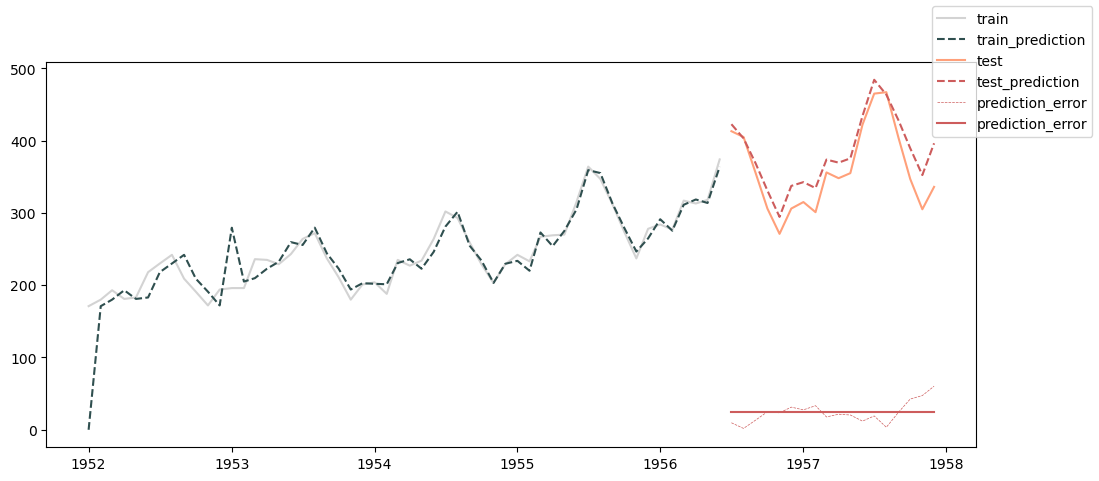

In [48]:
# Определение периода сезонности
period = 12  # Поскольку данные представлены на уровне месяца, период сезонности - 12 месяцев

# Обучение финальной SARIMA-модели на всех данных
SARIMAX_model = SARIMAX(train_target, order=(2, 1, 2), seasonal_order=(1, 1, 1, period)).fit()

# Прогноз на тестовой выборке
test_prediction = SARIMAX_model.predict(start=test_target.index[0], end=test_target.index[-1])
sarima_test_mae = mean_absolute_error(test_target, test_prediction)
train_prediction = SARIMAX_model.predict(start=train_target.index[0], end=train_target.index[-1])
sarima_train_mae = mean_absolute_error(train_target, train_prediction)

print(f"MAE на тестовой выборке: {sarima_test_mae:.2f}")
print(f"MAE на обучающей выборке: {sarima_train_mae:.2f}")

# Визуализация обучающей, валидационной и тестовой выборок, а также прогнозных значений
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * len(test['passengers']), index=test.index)

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsalmon', label='test')
ax.plot(test_prediction, c='indianred', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

9. _Выберите лучшую из обученных моделей и оцените ее качество на отложенной выборке_

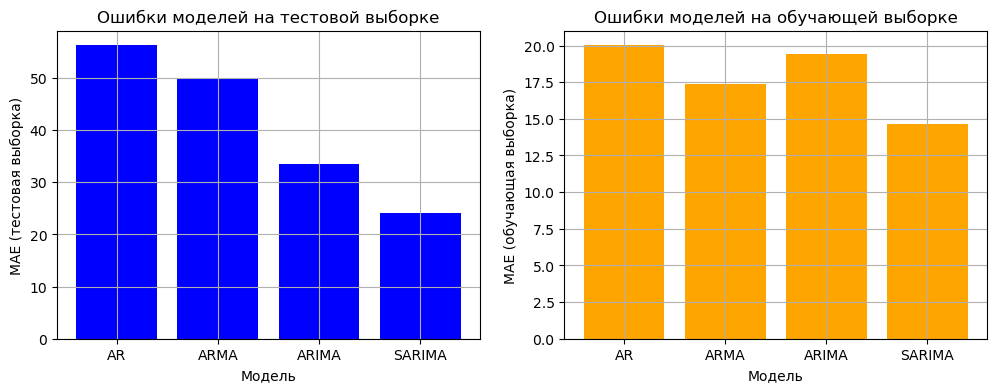

In [49]:
# Создаем списки моделей и их ошибок на тестовой и обучающей выборках
models = ['AR', 'ARMA', 'ARIMA', 'SARIMA']
test_maes = [ar_test_mae, arma_test_mae, arima_test_mae, sarima_test_mae]
train_maes = [ar_train_mae, arma_train_mae, arima_train_mae, sarima_train_mae]

# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Рисуем ошибки на тестовой выборке
ax1.bar(np.arange(len(models)), test_maes, color='b')
ax1.set_xlabel('Модель')
ax1.set_ylabel('MAE (тестовая выборка)')
ax1.set_title('Ошибки моделей на тестовой выборке')
ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models)
ax1.grid()

# Рисуем ошибки на обучающей выборке
ax2.bar(np.arange(len(models)), train_maes, color='orange')
ax2.set_xlabel('Модель')
ax2.set_ylabel('MAE (обучающая выборка)')
ax2.set_title('Ошибки моделей на обучающей выборке')
ax2.set_xticks(np.arange(len(models)))
ax2.set_xticklabels(models)
ax2.grid()

plt.show()

In [50]:
# Определение наилучшей модели
if sarima_test_mae < ar_test_mae and sarima_test_mae < arma_test_mae and sarima_test_mae < arima_test_mae:
    print("Наилучшая модель: SARIMA")
    print(f"MAE на тестовой выборке: {sarima_test_mae}")
elif ar_test_mae < arma_test_mae and ar_test_mae < arima_test_mae:
    print("Наилучшая модель: AR")
    print(f"MAE на тестовой выборке: {ar_test_mae}")
elif arma_test_mae < arima_test_mae:
    print("Наилучшая модель: ARMA")
    print(f"MAE на тестовой выборке: {arma_test_mae}")
else:
    print("Наилучшая модель: ARIMA")
    print(f"MAE на тестовой выборке: {arima_test_mae}")


Наилучшая модель: SARIMA
MAE на тестовой выборке: 24.12097945993835
